# Cell counting

We will examine the use of U-Nets to perform cell counting, a crucial task to determine the number of cells in cell cultures before and after treatment.

## Cell nuclei images

We used image set BBBC039v1 Caicedo et al. 2018, available from the Broad Bioimage Benchmark Collection https://data.broadinstitute.org/bbbc/BBBC039/ [Ljosa et al., Nature Methods, 2012].

This data set has a total of 200 fields of view of nuclei captured with fluorescence microscopy using the Hoechst stain. The collection has around 23,000 single nuclei manually annotated to establish a ground truth collection for segmentation evaluation.

The images are stored as TIFF files with 520x696 pixels at 16 bits. Ground truth annotations are stored as PNG files encoding masks of independent nuclei.
We download the data from the DeepTrackAI repository `cell_counting_dataset`. We use `Deeptrack2.1` to define sources where to load the data from during training and test.

In [1]:
import os
import deeptrack as dt

if not os.path.exists("cell_counting_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/cell_counting_dataset")

image_paths = dt.sources.ImageFolder(
    root=os.path.join("cell_counting_dataset", "cell nuclei", "images")
)
label_paths = dt.sources.ImageFolder(
    root=os.path.join("cell_counting_dataset", "cell nuclei", "masks")
)
sources = dt.sources.Source(image=image_paths, label=label_paths)

In [2]:
print(len(sources))

200


We write a pipeline to load the images and the corresponding masks and display a few examples, with the corresponding histograms. 

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader

im_pipeline = (dt.LoadImage(sources.image.path) >> dt.Divide(3000)
               >> dt.Clip(0, 1) >> dt.AsType("float"))
lab_pipeline = dt.LoadImage(sources.label.path)[..., :1] >> dt.AsType("float")

pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.Crop(crop=(512, 688, None), corner=(0, 0))
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

test_dataset = dt.pytorch.Dataset(pipeline, sources)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

To count the number of cells, we will use the number of connected components of the segmentaion mask, i.e. groups of adjacents pixels with the same value. 

For this, we can first _label_ the mask by assigning a different integer label to each component. We will verify it on the images we just displayed.

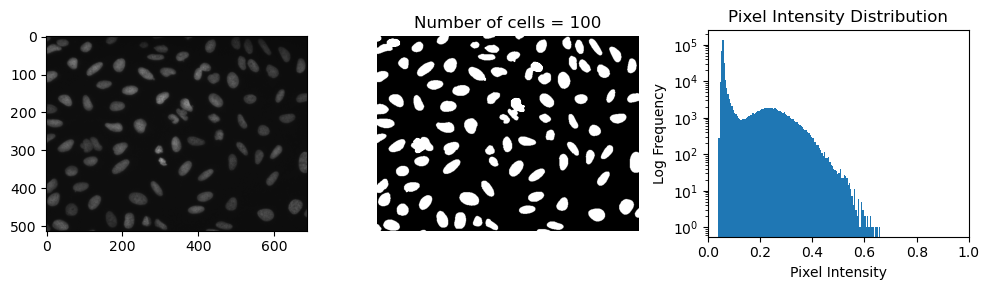

In [4]:
from matplotlib import pyplot as plt
from skimage import morphology as skmorph

image, mask = test_dataset[np.random.choice(len(test_dataset))]
labeled_mask = skmorph.label(mask)
number_of_cells = labeled_mask.max()
    
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].imshow(image.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")

axs[1].imshow(mask.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
axs[1].axis("off")
axs[1].set_title(f"Number of cells = {number_of_cells}")

axs[2].hist(np.array(image).flatten(), bins=200, range=(0, 1))
axs[2].set_xlim([0, 1])
axs[2].set_xlabel("Pixel Intensity")
axs[2].set_yscale("log")
axs[2].set_ylabel("Log Frequency")
axs[2].set_title("Pixel Intensity Distribution")

plt.tight_layout()
plt.show()

## Alternative simulations - not working!

## Simulations

We will use ``Deeptrack2.1`` to simulate fluorescently labeled cell nuclei, so to have a large labeled training dataset.

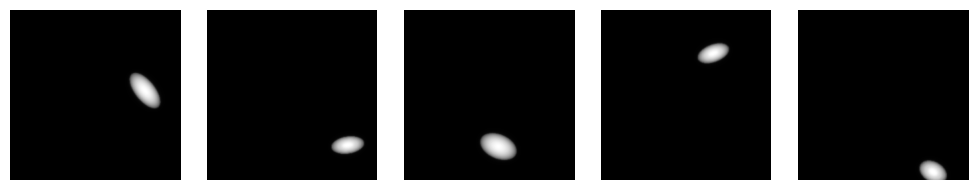

In [5]:
## SIM 1

training_image_size = 256

def random_ellipse_radius():
    desired_ellipse_area = (np.random.uniform(3, 4)) ** 2
    desired_radius_ratio = np.random.uniform(1, 1.5)
    major_axis_radius = np.sqrt(desired_ellipse_area) * desired_radius_ratio
    minor_axis_radius = np.sqrt(desired_ellipse_area) / desired_radius_ratio
    z_radius = np.sqrt(desired_ellipse_area) * np.random.uniform(0.2, 0.4)
    return (major_axis_radius, minor_axis_radius, z_radius) * dt.units.um

ellipse = dt.Ellipsoid(
    radius=random_ellipse_radius,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, training_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)

optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, training_image_size, training_image_size),
)

image_pipeline = optics(ellipse)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for ax in axs:
    image_pipeline.update()
    image = image_pipeline()
    ax.imshow(image, cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


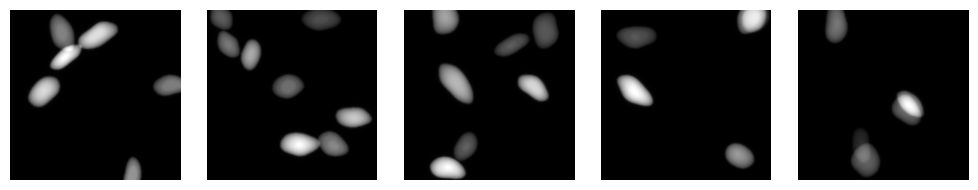

In [6]:
## SIM 2

training_image_size = 256

def random_ellipse_radius():
    desired_ellipse_area = (np.random.uniform(3, 4)) ** 2
    desired_radius_ratio = np.random.uniform(1, 1.5)
    major_axis_radius = np.sqrt(desired_ellipse_area) * desired_radius_ratio
    minor_axis_radius = np.sqrt(desired_ellipse_area) / desired_radius_ratio
    z_radius = np.sqrt(desired_ellipse_area) * np.random.uniform(0.2, 0.4)
    return (major_axis_radius, minor_axis_radius, z_radius) * dt.units.um

ellipse = dt.Ellipsoid(
    radius=random_ellipse_radius,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, training_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)

synthetic_cells = (
    (ellipse ^ (lambda: np.random.randint(5, 10)))
    >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)                                ### pad the cells to make the elastic transformation not get cropped
    >> dt.ElasticTransformation(alpha=100, sigma=10, order=1) 
    >> dt.CropTight()                                                              ### crop the padded cells to the original size. 
)

optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, training_image_size, training_image_size),
)

image_pipeline = optics(synthetic_cells)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for ax in axs:
    image_pipeline.update()
    image = image_pipeline()
    ax.imshow(image, cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


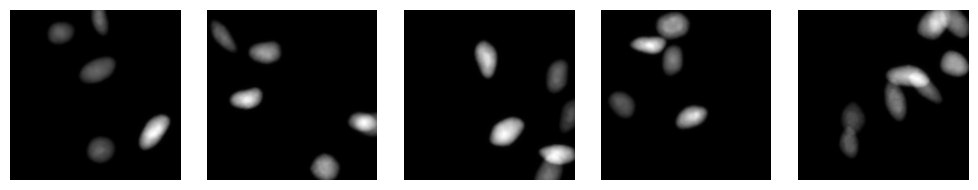

In [7]:
## SIM 3

training_image_size = 256

def random_ellipse_radius():
    desired_ellipse_area = (np.random.uniform(3, 4)) ** 2
    desired_radius_ratio = np.random.uniform(1, 1.5)
    major_axis_radius = np.sqrt(desired_ellipse_area) * desired_radius_ratio
    minor_axis_radius = np.sqrt(desired_ellipse_area) / desired_radius_ratio
    z_radius = np.sqrt(desired_ellipse_area) * np.random.uniform(0.2, 0.4)
    return (major_axis_radius, minor_axis_radius, z_radius) * dt.units.um

ellipse = dt.Ellipsoid(
    radius=random_ellipse_radius,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, training_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)

synthetic_cells = (
    (ellipse ^ (lambda: np.random.randint(5, 10)))
    >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)                                ### pad the cells to make the elastic transformation not get cropped
    >> dt.ElasticTransformation(alpha=100, sigma=10, order=1) 
    >> dt.CropTight()                                                              ### crop the padded cells to the original size. 
)

# Create a mask of the synthetic cell. This will be used to edge bleed from the blurred structural noise
synthetic_cells_mask = synthetic_cells > 0

# Add structural noise to the synthetic cell
long_range_noise = (
    synthetic_cells 
    >> dt.Poisson(snr=lambda: 0.2) 
    >> dt.GaussianBlur(sigma=3.5)
)
short_range_noise = (
    synthetic_cells 
    >> dt.Poisson(snr=lambda: 1.0) 
    >> dt.GaussianBlur(sigma=1.5)
) 
random_range_nosie = (
    synthetic_cells 
    >> dt.Poisson(snr=lambda: np.random.uniform(0.5, 1.5))
    >> dt.GaussianBlur(sigma=lambda: np.random.uniform(0.75, 1.5))
) 

noisy_synthetic_cells = synthetic_cells_mask * (
    long_range_noise + short_range_noise + random_range_nosie
) / 3 

optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, training_image_size, training_image_size),
)

image_pipeline = optics(noisy_synthetic_cells)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for ax in axs:
    image_pipeline.update()
    image = image_pipeline()
    ax.imshow(image, cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


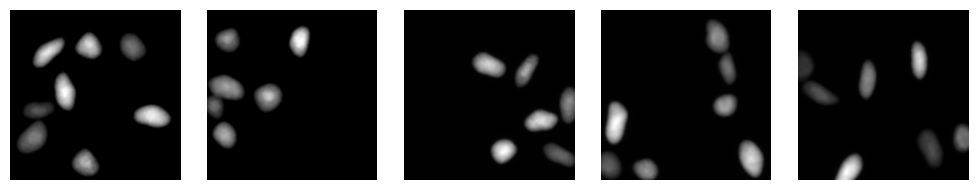

In [8]:
## SIM 4

training_image_size = 256

def random_ellipse_radius():
    desired_ellipse_area = (np.random.uniform(3, 4)) ** 2
    desired_radius_ratio = np.random.uniform(1, 1.5)
    major_axis_radius = np.sqrt(desired_ellipse_area) * desired_radius_ratio
    minor_axis_radius = np.sqrt(desired_ellipse_area) / desired_radius_ratio
    z_radius = np.sqrt(desired_ellipse_area) * np.random.uniform(0.2, 0.4)
    return (major_axis_radius, minor_axis_radius, z_radius) * dt.units.um

ellipse = dt.Ellipsoid(
    radius=random_ellipse_radius,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, training_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)

synthetic_cells = (
    (ellipse ^ (lambda: np.random.randint(5, 10)))
    >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)                                ### pad the cells to make the elastic transformation not get cropped
    >> dt.ElasticTransformation(alpha=100, sigma=10, order=1) 
    >> dt.CropTight()                                                              ### crop the padded cells to the original size. 
)

# Create a mask of the synthetic cell. This will be used to edge bleed from the blurred structural noise
synthetic_cells_mask = synthetic_cells > 0

# Add structural noise to the synthetic cell
long_range_noise = (
    synthetic_cells 
    >> dt.Poisson(snr=lambda: 0.2) 
    >> dt.GaussianBlur(sigma=3.5)
)
short_range_noise = (
    synthetic_cells 
    >> dt.Poisson(snr=lambda: 1.0) 
    >> dt.GaussianBlur(sigma=1.5)
) 
random_range_nosie = (
    synthetic_cells 
    >> dt.Poisson(snr=lambda: np.random.uniform(0.5, 1.5))
    >> dt.GaussianBlur(sigma=lambda: np.random.uniform(0.75, 1.5))
) 

noisy_synthetic_cells = synthetic_cells_mask * (
    long_range_noise + short_range_noise + random_range_nosie
) / 3 

# Create a non-overlapping version of the synthetic cell
non_overlap_cells = dt.NonOverlapping(noisy_synthetic_cells, min_distance=-6)                                  ### min_distance=-6 to allow the cells overlap a little bit

optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, training_image_size, training_image_size),
)

image_pipeline = (optics(non_overlap_cells)
                  >> dt.Gaussian(sigma=lambda: np.random.uniform(0, 0.1))
                  >> dt.Divide(lambda: np.random.uniform(14, 20))
                  >> dt.Add(lambda: np.random.uniform(-0.05, 0.15))
                  >> dt.Clip(0, 1)
                  >> dt.AsType("float"))

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for ax in axs:
    image_pipeline.update()
    image = image_pipeline()
    ax.imshow(image, cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


We also need to provide target images that will be used to quantify the number of cells. As a first approximation, we simply use the segmentation map. 

This function generates and returns an inner function that performs the following steps on a given mask:
    1. Converts the input mask to a binary mask by summing across the last dimension and checking if the sum is greater than 0.
    2. Pads the binary mask with a constant value (0) on all sides.
    3. Applies isotropic erosion to the padded mask using the specified radius.
    4. Removes the padding from the eroded mask and returns the result.


In [9]:
from skimage.morphology import isotropic_erosion

def get_mask(radius):
    """Apply isotropic erosion to a binary mask."""
    def inner(mask):
        mask = np.sum(mask, -1, keepdims=True) > 0                              # Converts the input mask to a binary mask by summing across the last dimension and checking if the sum is greater than 0.
        mask = np.pad(mask, [(1, 1), (1, 1), (0, 0)], mode="constant")          # Pads the binary mask with a constant value (0) on all sides.
        mask = isotropic_erosion(mask, radius=radius)                           # Applies isotropic erosion to the padded mask using the specified radius.
        mask = mask[1:-1, 1:-1]                                                 # Removes the padding from the eroded mask and returns the result.
        return mask
    return inner

label_pipeline = (
    non_overlap_cells
    >> dt.SampleToMasks(get_mask, radius=6,
                        output_region=optics.output_region,
                        merge_method="or")
    >> dt.AsType("float")
)

In [10]:
image_and_gt_pipeline = (
    (image_pipeline & label_pipeline)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

train_dataset = dt.pytorch.Dataset(image_and_gt_pipeline, 
                                   length=640, 
                                   replace=0.01) 

We display a few examples of simulated images with the corresponding masks and histograms.

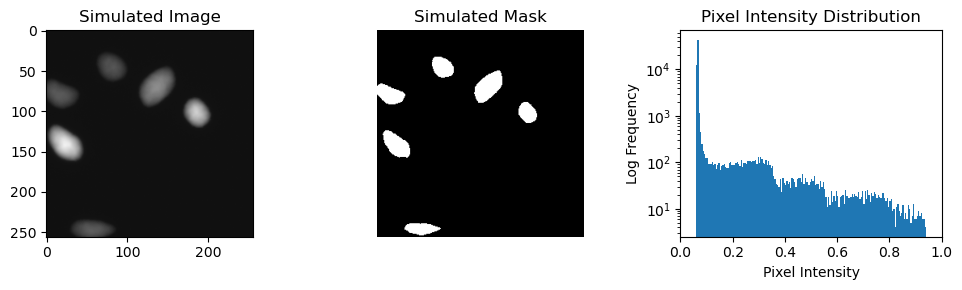

In [11]:

image, mask = train_dataset[np.random.choice(len(train_dataset))]

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].imshow(image.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Simulated Image")

axs[1].imshow(mask.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
axs[1].axis("off")
axs[1].set_title("Simulated Mask")

axs[2].hist(np.array(image).flatten(), bins=200, range=(0, 1))
axs[2].set_xlim([0, 1])
axs[2].set_xlabel("Pixel Intensity")
axs[2].set_yscale("log")
axs[2].set_ylabel("Log Frequency")
axs[2].set_title("Pixel Intensity Distribution")

plt.tight_layout()
plt.show()

## UNet

We will use a UNet to segment the cells.

In [12]:
import deeplay as dl

unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=1,
)

In [13]:
print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

We use the binary crossentropy loss

In [14]:
from torch.nn import BCEWithLogitsLoss

unet_regressor = dl.Regressor(
    model=unet,
    loss=BCEWithLogitsLoss(),
    optimizer=dl.Adam(),
).create()

We train the network for 50 epochs.

In [15]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
unet_trainer = dl.Trainer(max_epochs=200, accelerator="auto")
unet_trainer.fit(unet_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-02-13 12:41:54.053841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Let's first test the network on the simulated data.

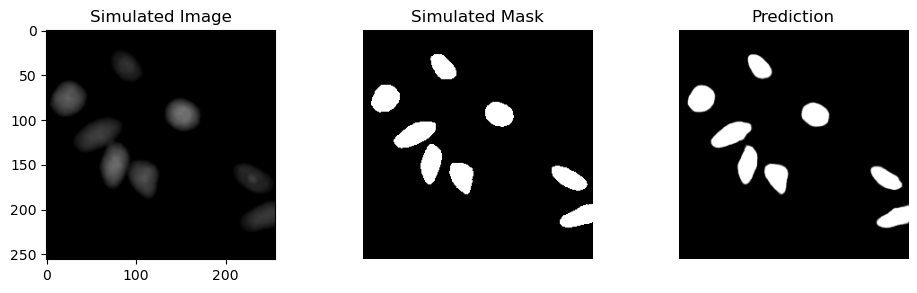

In [21]:

from matplotlib import pyplot as plt

image_and_gt_pipeline.update()
image, mask = image_and_gt_pipeline()
pred = unet_regressor(image.unsqueeze(0)).sigmoid().detach()
    
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].imshow(image.squeeze(), vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Simulated Image")

axs[1].imshow(mask.squeeze(), vmin=0, vmax=1, cmap="gray")
axs[1].axis("off")
axs[1].set_title("Simulated Mask")

axs[2].imshow(pred.squeeze(), cmap="gray")
axs[2].axis("off")
axs[2].set_title("Prediction")

plt.tight_layout()
plt.show()

We'll apply it to all the images in the test set and calculate true and predicted number of cells.

In [17]:
images, labels, preds = [], [], []
for image, label in test_loader:
    images.append(image)
    labels.append(label)
    pred = unet_regressor(image).detach()                                 ### pr = unet_regressor(im.to("cuda")).detach()
    pred = torch.nn.functional.sigmoid(pred).cpu()
    preds.append(pred)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)

true_count = np.array([skmorph.label(l.squeeze()).max() for l in labels])               # Count connected components
pred_count = np.array([skmorph.label(p.squeeze() > 0.995).max() for p in preds])        # Count connected components

We calculate MAE and MPE and display the results in a scatterplot.

In [18]:
mae = abs(pred_count - true_count).mean()
mpe = (abs(pred_count[true_count > 0] - true_count[true_count > 0]) 
       / (true_count[true_count > 0])).mean()

print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}")

MAE: 8.54
MPE: 0.08


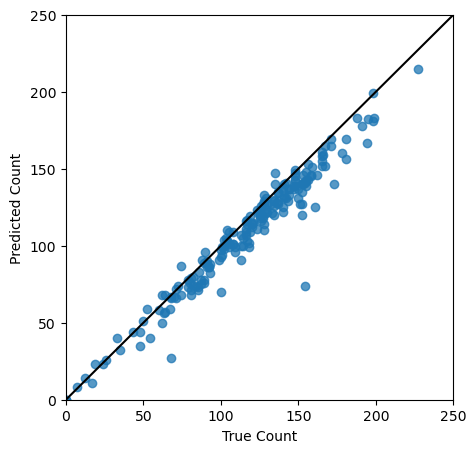

In [19]:
plt.figure(figsize=(5, 5))
plt.scatter(true_count, pred_count, alpha=0.75)
plt.axline([0, 0], [1, 1], color="black")
plt.xlabel("True Count")
plt.ylabel("Predicted Count")
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()

...and visually check the predictions.

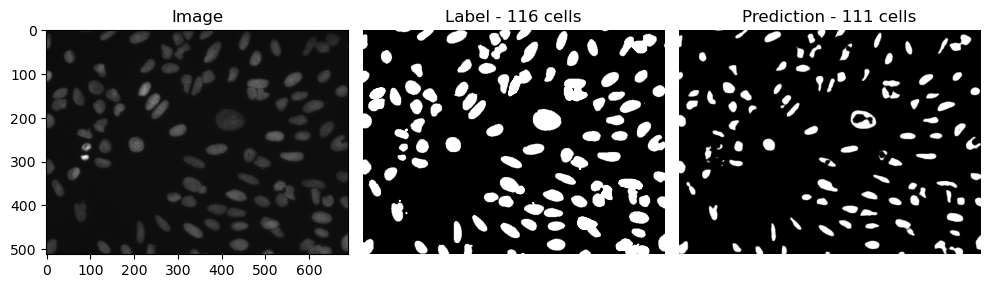

In [20]:
i = np.random.choice(len(images))
    
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].imshow(images[i].squeeze(), vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Image")

axs[1].imshow(labels[i].squeeze(), vmin=0, vmax=1, cmap="gray")
axs[1].axis("off")
axs[1].set_title(f"Label - {true_count[i]} cells")

axs[2].imshow(preds[i].squeeze(), cmap="gray")
axs[2].axis("off")
axs[2].set_title(f"Prediction - {pred_count[i]} cells")

plt.tight_layout()
plt.show()